# <font color="green"> **NLP Project: Intent Classification**
*Vialard Louis, Lapidus Lukas*

</br>

**Project Summary:**
- Datasets exploration
- Tokenization
- Models
- Results

## Installs

In [273]:
!pip install transformers
!pip install datasets
!pip install torchinfo
!pip install torchtext
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 6.5 MB/s eta 0:00:00


## Imports

In [281]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torch.optim as optim
import evaluate

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler, TrainingArguments, Trainer

from datasets import load_dataset, DatasetDict
from collections import Counter

import nltk
from nltk.tokenize import TweetTokenizer
from tqdm import tqdm


from torchtext.vocab import FastText, vocab

## Fast-Text Pre-trained Embeddings

In [27]:
pretrained_vectors = FastText(language='en')

In [28]:
pretrained_vectors.vectors.size()

torch.Size([2519370, 300])

We build a vocabulary with `<unk>` and `<pad>` tokens:

In [29]:
pretrained_vocab = vocab(pretrained_vectors.stoi)

unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1

pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)
pretrained_vocab.set_default_index(unk_index)

Examples of vocabulary indexes:

In [30]:
print("<pad> index:", pretrained_vocab.get_stoi()['<pad>'], "\n")

print("'.' old index in vocab:", pretrained_vectors.stoi["."])
print("'.' new index in vocab:", pretrained_vocab.get_stoi()["."])

# , is not recognized :
print("',' is considered as <unk>:", pretrained_vocab[","])

<pad> index: 1 

'.' old index in vocab: 1
'.' new index in vocab: 2
',' is considered as <unk>: 0


Pretrained vector:

In [31]:
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([2519371, 300])

## Data Exploration: Map Task

Map Task dataset:
- Speaker: sex of the speaker
- Utterance: Dialogue content
- Dialogue_Act: Dialogue class (12 classes to predict)
- Label: Dialogue_Act as integers
- Idx: Utterance id

Size: `{'train': 20905, 'validation': 2963, 'test': 2894}`

Dialogue_Act: ```['instruct', 'acknowledge', 'align', 'reply_y', 'query_yn', 'check', 'clarify', 'reply_n', 'explain', 'reply_w', 'ready', 'query_w']```



### Load dataset

In [55]:
dataset_mt = load_dataset("silicone", "maptask")
dataset_mt

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Label', 'Idx'],
        num_rows: 20905
    })
    validation: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Label', 'Idx'],
        num_rows: 2963
    })
    test: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Label', 'Idx'],
        num_rows: 2894
    })
})

In [56]:
dataset_mt.num_rows

{'train': 20905, 'validation': 2963, 'test': 2894}

In [57]:
print(dataset_mt['train'][0])

{'Speaker': 'g', 'Utterance': 'okay the start part is at the top left-hand corner', 'Dialogue_Act': 'instruct', 'Label': 5, 'Idx': 0}


### Dialog Act

In [58]:
# Convertion dictionnary: Label to Dialogue_Act
label_tags = {}
for i in range(100):
  label_tags[dataset_mt['train'][i]["Label"]] = dataset_mt['train'][i]["Dialogue_Act"]

print(label_tags)


{5: 'instruct', 0: 'acknowledge', 1: 'align', 11: 'reply_y', 7: 'query_yn', 2: 'check', 3: 'clarify', 9: 'reply_n', 4: 'explain', 10: 'reply_w', 8: 'ready', 6: 'query_w'}


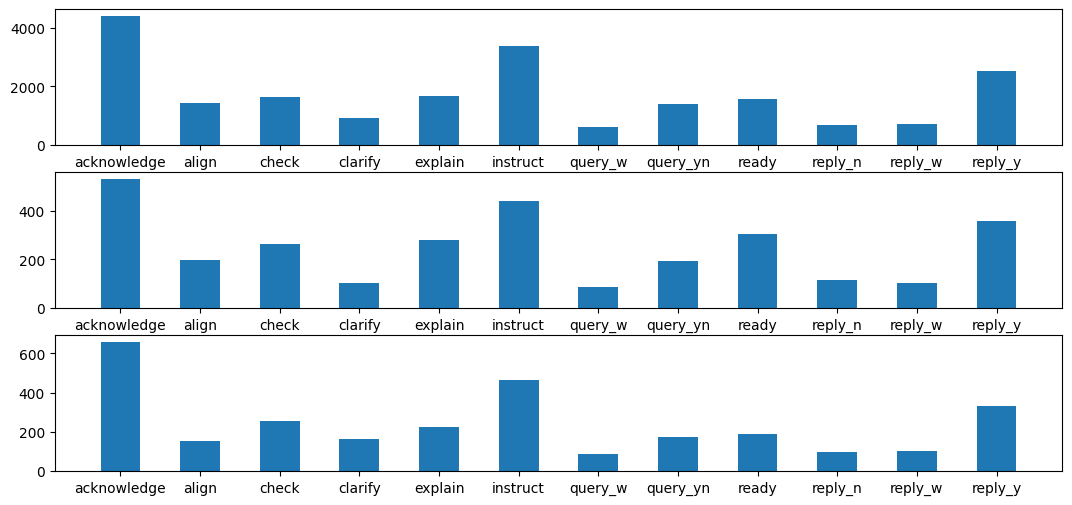

In [59]:
label_counters = {}

for split in ["train", "validation", "test"]:
  label_counters[split] = Counter(dataset_mt[split]['Label'])

# Plotting bar charts
plt.figure(figsize=(13,6))

split = 'train'
tick_label = [label_tags[ind] for ind in label_counters[split].keys()] # Converting indexes (Label) to Dialogue_Acts
plt.subplot(311)
plt.bar(label_counters[split].keys(), label_counters[split].values(), width=0.5, tick_label=tick_label, label=split)

split = 'validation'
tick_label = [label_tags[ind] for ind in label_counters[split].keys()] # Converting indexes (Label) to Dialogue_Acts
plt.subplot(312)
plt.bar(label_counters[split].keys(), label_counters[split].values(), width=0.5, tick_label=tick_label, label=split)

split = 'test'
tick_label = [label_tags[ind] for ind in label_counters[split].keys()] # Converting indexes (Label) to Dialogue_Acts
plt.subplot(313)
plt.bar(label_counters[split].keys(), label_counters[split].values(), width=0.5, tick_label=tick_label, label=split)

plt.show()

### Speaker: Not used

Counter({'g': 11765, 'f': 9140})


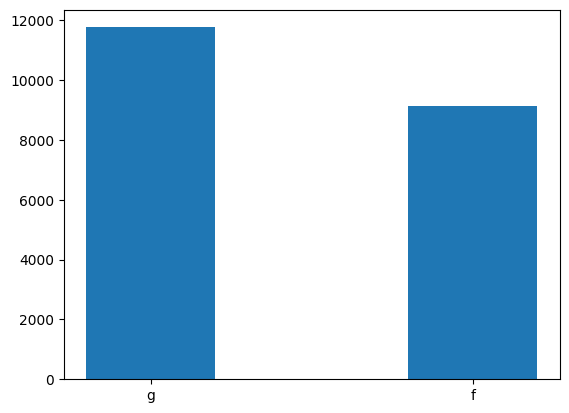

In [60]:
speaker_counter = Counter(dataset_mt['train']['Speaker'])

print(speaker_counter)

plt.bar(speaker_counter.keys(), speaker_counter.values(), width=0.4)
plt.show()

### Sentence length (with space splitting)

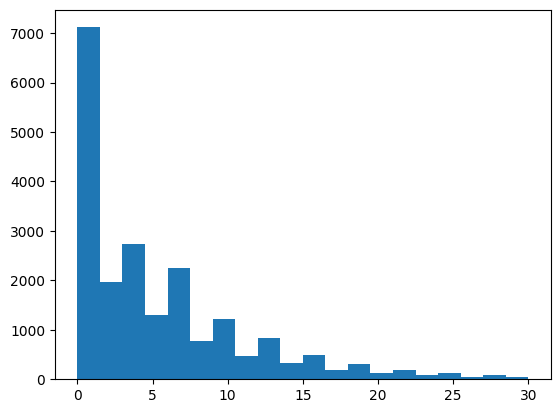

In [145]:
lengths = list(map(lambda s: len(s.split(" ")), dataset_mt['train']['Utterance']))

plt.hist(lengths, bins=20, range=(0,30))
plt.show()

## Data Handling: MRDA dataset

MRDA dataset :
- Utterance_ID : sentence id
- Dialogue_Act : the type of sentence (5 classes to predict)
- Channel_ID : The Channel id
- Speaker : The Speaker id
- Dialogue_ID : The dialogue id containing the channels and speakers
- Uterrance : The dialogue content
- Label : The class label (equivalent to Dialogue_Act)
- Idx : integer index of the dataset

Size: `{'train': 83943, 'validation': 9815, 'test': 15470}`

Dialogue_Act:
```
"s": "Statement/Subjective Statement"
"d": "Declarative Question"
"b": "Backchannel"
"f": "Follow-me"
"q": "Question"
```

### Load Dataset

In [62]:
dataset_mrda = load_dataset("silicone", "mrda")
dataset_mrda

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Utterance_ID', 'Dialogue_Act', 'Channel_ID', 'Speaker', 'Dialogue_ID', 'Utterance', 'Label', 'Idx'],
        num_rows: 83943
    })
    validation: Dataset({
        features: ['Utterance_ID', 'Dialogue_Act', 'Channel_ID', 'Speaker', 'Dialogue_ID', 'Utterance', 'Label', 'Idx'],
        num_rows: 9815
    })
    test: Dataset({
        features: ['Utterance_ID', 'Dialogue_Act', 'Channel_ID', 'Speaker', 'Dialogue_ID', 'Utterance', 'Label', 'Idx'],
        num_rows: 15470
    })
})

In [63]:
dataset_mrda.num_rows

{'train': 83943, 'validation': 9815, 'test': 15470}

In [76]:
print(list(dataset_mrda['train'].features))
dataset_mrda['train'][0]

['Utterance_ID', 'Dialogue_Act', 'Channel_ID', 'Speaker', 'Dialogue_ID', 'Utterance', 'Label', 'Idx']


{'Utterance_ID': 'Bed002-c8_0005790_0006200',
 'Dialogue_Act': 's',
 'Channel_ID': 'Bed002-c8',
 'Speaker': 'me003',
 'Dialogue_ID': 'Bed002',
 'Utterance': 'i guess .',
 'Label': 0,
 'Idx': 0}

### Dialog Act

In [65]:
# Convertion dictionnary: label to dialogue act
label_tags = {}
for i in range(100):
  label_tags[dataset_mrda['train'][i]["Label"]] = dataset_mrda['train'][i]["Dialogue_Act"]

print(label_tags)

{0: 's', 4: 'q', 1: 'd', 2: 'b', 3: 'f'}


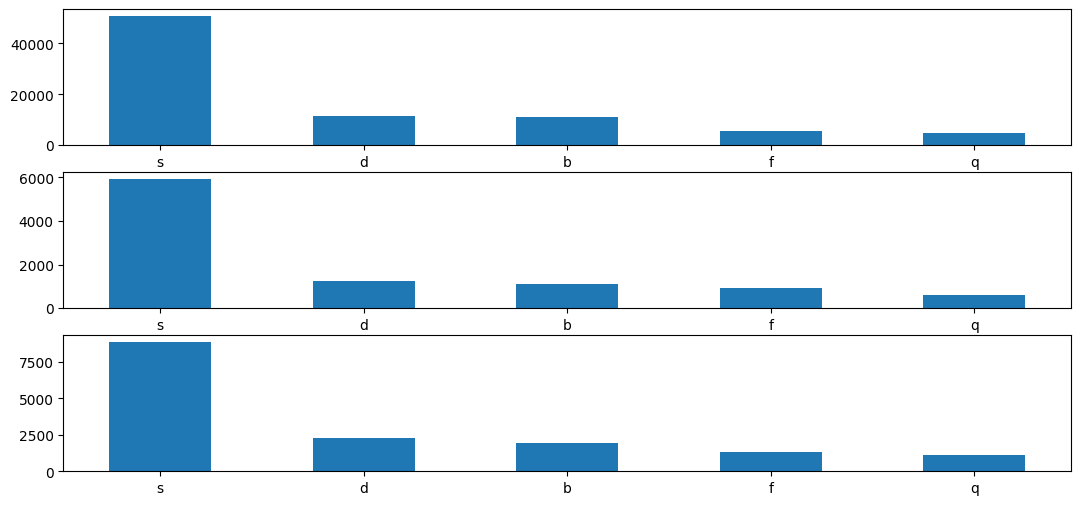

In [66]:
label_counters = {}

for split in ["train", "validation", "test"]:
  label_counters[split] = Counter(dataset_mrda[split]['Label'])

# Plotting bar charts
plt.figure(figsize=(13,6))

split = 'train'
tick_label = [label_tags[ind] for ind in label_counters[split].keys()] # Converting indexes (Label) to Dialogue_Acts
plt.subplot(311)
plt.bar(label_counters[split].keys(), label_counters[split].values(), width=0.5, tick_label=tick_label, label=split)

split = 'validation'
tick_label = [label_tags[ind] for ind in label_counters[split].keys()] # Converting indexes (Label) to Dialogue_Acts
plt.subplot(312)
plt.bar(label_counters[split].keys(), label_counters[split].values(), width=0.5, tick_label=tick_label, label=split)

split = 'test'
tick_label = [label_tags[ind] for ind in label_counters[split].keys()] # Converting indexes (Label) to Dialogue_Acts
plt.subplot(313)
plt.bar(label_counters[split].keys(), label_counters[split].values(), width=0.5, tick_label=tick_label, label=split)

plt.show()

### Speaker: Not used

Counter({'me013': 15384, 'fe008': 7773, 'me011': 7434, 'me018': 5447, 'mn007': 4879, 'fe016': 4626, 'mn015': 4070, 'me010': 3949, 'mn017': 2948, 'fe004': 2467, 'mn082': 1978, 'mn005': 1681, 'me045': 1510, 'mn021': 1428, 'fe069': 1357, 'me003': 1197, 'me006': 1177, 'mn014': 1094, 'me025': 1073, 'fe066': 1004, 'me001': 915, 'me070': 880, 'mn052': 879, 'fn002': 819, 'fe068': 798, 'me012': 790, 'mn049': 737, 'me028': 625, 'me026': 612, 'fe041': 462, 'mn081': 423, 'me022': 405, 'mn038': 398, 'me056': 352, 'me055': 274, 'mn030': 254, 'mn048': 245, 'fn083': 226, 'fe067': 220, 'fn050': 200, 'mn059': 165, 'mn036': 150, 'mn047': 149, 'mn035': 136, 'me034': 95, 'mn057': 95, 'fe046': 46, 'fn043': 41, 'mn040': 35, 'me051': 30, 'mn009': 11})


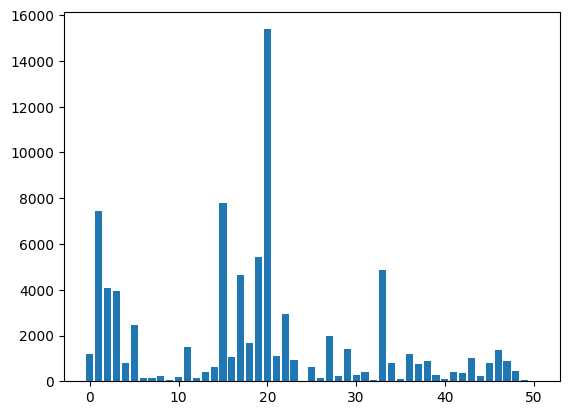

In [67]:
speaker_counter = Counter(dataset_mrda['train']['Speaker'])

print(speaker_counter)

plt.bar(range(len(speaker_counter)), speaker_counter.values(), width=0.8)
plt.show()

### Sentence length (with space splitting)

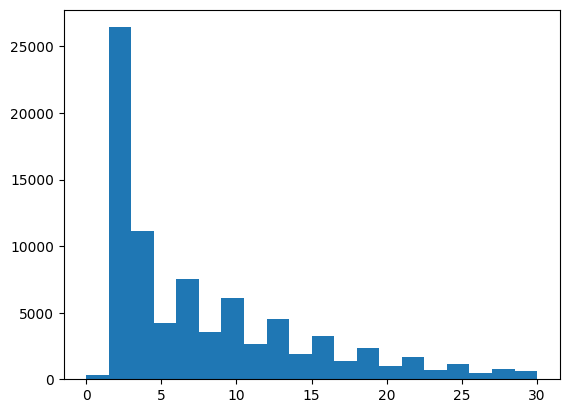

In [68]:
lengths = list(map(lambda s: len(s.split(" ")), dataset_mrda['train']['Utterance']))

plt.hist(lengths, bins=20, range=(0,30))
plt.show()

## Data Handling: LORIA dataset (French)

LORIA dataset from MIAM :
- Dialogue_Act : the type of sentence (31 classes to predict)
- File_ID : The Dialogue id
- Speaker : The Speaker name
- Dialogue_ID : The dialogue id containing the utterances
- Uterrance : The dialogue content in French
- Label : The class label (equivalent to Dialogue_Act)
- Idx : integer index of the dataset

Size: `{'train': 8465, 'validation': 942, 'test': 1047}`

Dialogue_Act:
```['ack' 'ask' 'find_mold' 'find_plans' 'first_step' 'greet' 'help' 'inform'
 'inform_engine' 'inform_job' 'inform_material_space'
 'informer_conditioner' 'informer_decoration' 'informer_elcomps'
 'informer_end_manufacturing' 'kindAtt' 'manufacturing_reqs' 'next_step'
 'no' 'other' 'quality_control' 'quit' 'reqRep' 'security_policies'
 'staff_enterprise' 'staff_job' 'studies_enterprise' 'studies_job'
 'todo_failure' 'todo_irreparable' 'yes']```

### Load Dataset

In [136]:
dataset_loria = load_dataset("miam", "loria")
dataset_loria

Generating train split:   0%|          | 0/8465 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/942 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1047 [00:00<?, ? examples/s]

Dataset miam downloaded and prepared to /root/.cache/huggingface/datasets/miam/loria/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 8465
    })
    validation: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 942
    })
    test: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 1047
    })
})

In [137]:
dataset_loria.num_rows

{'train': 8465, 'validation': 942, 'test': 1047}

In [138]:
print(list(dataset_loria['train'].features))
dataset_loria['train'][0]

['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx']


{'Speaker': 'Lucas',
 'Utterance': 'Alors!',
 'Dialogue_Act': 'greet',
 'Dialogue_ID': '0',
 'File_ID': 'Dial_20110615_105040',
 'Label': 5,
 'Idx': 0}

### Dialog Act

In [222]:
# Convertion dictionnary: label to dialogue act
label_tags = {}
for i in range(dataset_loria.num_rows["train"]):
  label_tags[dataset_loria['train'][i]["Label"]] = dataset_loria['train'][i]["Dialogue_Act"]

print(label_tags)
print(len(label_tags))
print(np.unique(list(label_tags.values())))

{5: 'greet', 1: 'ask', 6: 'help', 7: 'inform', 21: 'quit', 3: 'find_plans', 25: 'staff_job', 23: 'security_policies', 19: 'other', 9: 'inform_job', 30: 'yes', 8: 'inform_engine', 20: 'quality_control', 18: 'no', 4: 'first_step', 0: 'ack', 28: 'todo_failure', 13: 'informer_elcomps', 17: 'next_step', 29: 'todo_irreparable', 16: 'manufacturing_reqs', 2: 'find_mold', 10: 'inform_material_space', 27: 'studies_job', 14: 'informer_end_manufacturing', 11: 'informer_conditioner', 12: 'informer_decoration', 24: 'staff_enterprise', 22: 'reqRep', 26: 'studies_enterprise', 15: 'kindAtt'}
31
['ack' 'ask' 'find_mold' 'find_plans' 'first_step' 'greet' 'help' 'inform'
 'inform_engine' 'inform_job' 'inform_material_space'
 'informer_conditioner' 'informer_decoration' 'informer_elcomps'
 'informer_end_manufacturing' 'kindAtt' 'manufacturing_reqs' 'next_step'
 'no' 'other' 'quality_control' 'quit' 'reqRep' 'security_policies'
 'staff_enterprise' 'staff_job' 'studies_enterprise' 'studies_job'
 'todo_failur

{'train': Counter({7: 1750, 1: 1698, 21: 1213, 5: 1140, 30: 576, 0: 395, 18: 251, 17: 219, 19: 205, 6: 191, 16: 89, 3: 84, 9: 82, 20: 73, 4: 70, 14: 70, 13: 68, 2: 48, 29: 46, 10: 41, 11: 32, 28: 22, 12: 22, 23: 16, 27: 15, 26: 14, 24: 12, 25: 11, 8: 5, 22: 5, 15: 2}), 'validation': Counter({7: 198, 1: 180, 5: 133, 21: 129, 30: 69, 0: 52, 6: 29, 18: 29, 19: 20, 17: 17, 13: 12, 3: 12, 16: 10, 2: 8, 20: 7, 9: 5, 24: 4, 4: 4, 29: 3, 12: 3, 23: 3, 14: 3, 10: 2, 28: 2, 25: 2, 11: 2, 15: 2, 8: 1, 27: 1}), 'test': Counter({7: 218, 1: 215, 21: 156, 5: 140, 30: 67, 0: 45, 6: 31, 18: 30, 17: 25, 3: 19, 19: 16, 4: 15, 9: 11, 10: 8, 13: 8, 20: 8, 16: 6, 14: 6, 23: 5, 28: 4, 29: 4, 27: 4, 25: 2, 2: 2, 12: 1, 11: 1})}


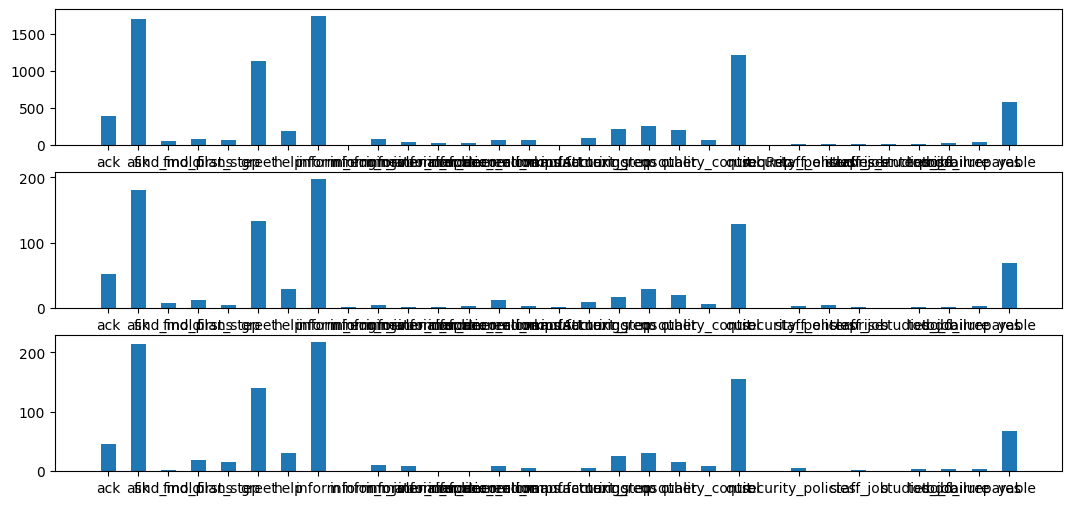

In [175]:
label_counters = {}

for split in ["train", "validation", "test"]:
  label_counters[split] = Counter(dataset_loria[split]['Label'])

print(label_counters)
# Plotting bar charts
plt.figure(figsize=(13,6))

split = 'train'
tick_label = [label_tags[ind] for ind in label_counters[split].keys()] # Converting indexes (Label) to Dialogue_Acts
plt.subplot(311)
plt.bar(label_counters[split].keys(), label_counters[split].values(), width=0.5, tick_label=tick_label, label=split)

split = 'validation'
tick_label = [label_tags[ind] for ind in label_counters[split].keys()] # Converting indexes (Label) to Dialogue_Acts
plt.subplot(312)
plt.bar(label_counters[split].keys(), label_counters[split].values(), width=0.5, tick_label=tick_label, label=split)

split = 'test'
tick_label = [label_tags[ind] for ind in label_counters[split].keys()] # Converting indexes (Label) to Dialogue_Acts
plt.subplot(313)
plt.bar(label_counters[split].keys(), label_counters[split].values(), width=0.5, tick_label=tick_label, label=split)

plt.show()

### Speaker: Not used

Counter({'me013': 15384, 'fe008': 7773, 'me011': 7434, 'me018': 5447, 'mn007': 4879, 'fe016': 4626, 'mn015': 4070, 'me010': 3949, 'mn017': 2948, 'fe004': 2467, 'mn082': 1978, 'mn005': 1681, 'me045': 1510, 'mn021': 1428, 'fe069': 1357, 'me003': 1197, 'me006': 1177, 'mn014': 1094, 'me025': 1073, 'fe066': 1004, 'me001': 915, 'me070': 880, 'mn052': 879, 'fn002': 819, 'fe068': 798, 'me012': 790, 'mn049': 737, 'me028': 625, 'me026': 612, 'fe041': 462, 'mn081': 423, 'me022': 405, 'mn038': 398, 'me056': 352, 'me055': 274, 'mn030': 254, 'mn048': 245, 'fn083': 226, 'fe067': 220, 'fn050': 200, 'mn059': 165, 'mn036': 150, 'mn047': 149, 'mn035': 136, 'me034': 95, 'mn057': 95, 'fe046': 46, 'fn043': 41, 'mn040': 35, 'me051': 30, 'mn009': 11})


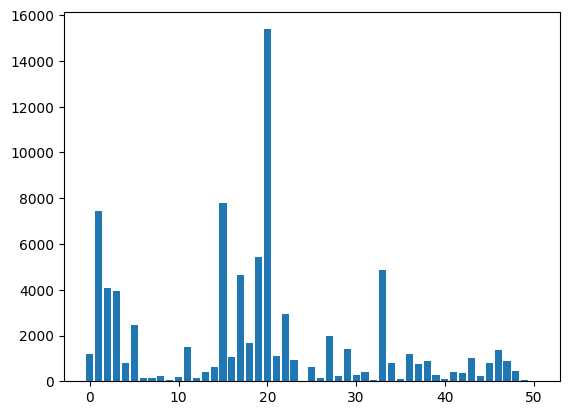

In [ ]:
speaker_counter = Counter(dataset_loria['train']['Speaker'])

print(speaker_counter)

plt.bar(range(len(speaker_counter)), speaker_counter.values(), width=0.8)
plt.show()

### Sentence length (with space splitting)

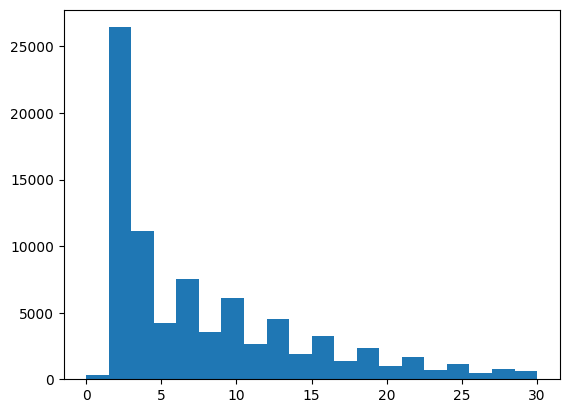

In [ ]:
lengths = list(map(lambda s: len(s.split(" ")), dataset_loria['train']['Utterance']))

plt.hist(lengths, bins=20, range=(0,30))
plt.show()

## Data Handling: VM2 dataset (German)

VM2 dataset from MIAM :
- Dialogue_Act : the type of sentence (31 classes to predict)
- Speaker : The Speaker tag (A or B)
- Dialogue_ID : The dialogue id containing the utterances
- Uterrance : The dialogue content in German
- Label : The class label (equivalent to Dialogue_Act)
- Idx : integer index of the dataset

Size: `{'train': 25060, 'validation': 2860, 'test': 2855}`

Dialogue_Act:
```['INTRODUCE', 'INIT', 'GREET', 'REQUEST_SUGGEST', 'INFORM', 'REQUEST_COMMENT', 'FEEDBACK_POSITIVE', 'DELIBERATE', 'SUGGEST', 'BACKCHANNEL', 'REJECT', 'ACCEPT', 'NOT_CLASSIFIABLE', 'CONFIRM', 'GIVE_REASON', 'REQUEST_COMMIT', 'COMMIT', 'BYE', 'CLOSE', 'EXCLUDE', 'OFFER', 'DEFER', 'POLITENESS_FORMULA', 'REQUEST', 'CLARIFY', 'FEEDBACK', 'REQUEST_CLARIFY', 'FEEDBACK_NEGATIVE', 'THANK', 'EXPLAINED_REJECT', 'DEVIATE_SCENARIO']```

### Load Dataset

In [200]:
dataset_vm2 = load_dataset("miam", "vm2")
dataset_vm2

Generating train split:   0%|          | 0/25060 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2860 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2855 [00:00<?, ? examples/s]

Dataset miam downloaded and prepared to /root/.cache/huggingface/datasets/miam/vm2/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Utterance', 'Dialogue_Act', 'Speaker', 'Dialogue_ID', 'Label', 'Idx'],
        num_rows: 25060
    })
    validation: Dataset({
        features: ['Utterance', 'Dialogue_Act', 'Speaker', 'Dialogue_ID', 'Label', 'Idx'],
        num_rows: 2860
    })
    test: Dataset({
        features: ['Utterance', 'Dialogue_Act', 'Speaker', 'Dialogue_ID', 'Label', 'Idx'],
        num_rows: 2855
    })
})

In [201]:
dataset_vm2.num_rows

{'train': 25060, 'validation': 2860, 'test': 2855}

In [202]:
print(list(dataset_vm2['train'].features))
dataset_vm2['train'][0]

['Utterance', 'Dialogue_Act', 'Speaker', 'Dialogue_ID', 'Label', 'Idx']


{'Utterance': 'mein Name ist Keller $K $E Doppel-$L $E $R',
 'Dialogue_Act': 'INTRODUCE',
 'Speaker': 'A',
 'Dialogue_ID': '1',
 'Label': 19,
 'Idx': 0}

### Dialog Act

In [224]:
# Convertion dictionnary: label to dialogue act
label_tags = {}
for i in range(dataset_vm2.num_rows["train"]):
  label_tags[dataset_vm2['train'][i]["Label"]] = dataset_vm2['train'][i]["Dialogue_Act"]

print(label_tags)
print(len(label_tags))
print(list(label_tags.values()))

{19: 'INTRODUCE', 18: 'INIT', 16: 'GREET', 28: 'REQUEST_SUGGEST', 17: 'INFORM', 26: 'REQUEST_COMMENT', 14: 'FEEDBACK_POSITIVE', 8: 'DELIBERATE', 29: 'SUGGEST', 1: 'BACKCHANNEL', 23: 'REJECT', 0: 'ACCEPT', 20: 'NOT_CLASSIFIABLE', 6: 'CONFIRM', 15: 'GIVE_REASON', 27: 'REQUEST_COMMIT', 5: 'COMMIT', 2: 'BYE', 4: 'CLOSE', 10: 'EXCLUDE', 21: 'OFFER', 7: 'DEFER', 22: 'POLITENESS_FORMULA', 24: 'REQUEST', 3: 'CLARIFY', 12: 'FEEDBACK', 25: 'REQUEST_CLARIFY', 13: 'FEEDBACK_NEGATIVE', 30: 'THANK', 11: 'EXPLAINED_REJECT', 9: 'DEVIATE_SCENARIO'}
31
['INTRODUCE', 'INIT', 'GREET', 'REQUEST_SUGGEST', 'INFORM', 'REQUEST_COMMENT', 'FEEDBACK_POSITIVE', 'DELIBERATE', 'SUGGEST', 'BACKCHANNEL', 'REJECT', 'ACCEPT', 'NOT_CLASSIFIABLE', 'CONFIRM', 'GIVE_REASON', 'REQUEST_COMMIT', 'COMMIT', 'BYE', 'CLOSE', 'EXCLUDE', 'OFFER', 'DEFER', 'POLITENESS_FORMULA', 'REQUEST', 'CLARIFY', 'FEEDBACK', 'REQUEST_CLARIFY', 'FEEDBACK_NEGATIVE', 'THANK', 'EXPLAINED_REJECT', 'DEVIATE_SCENARIO']


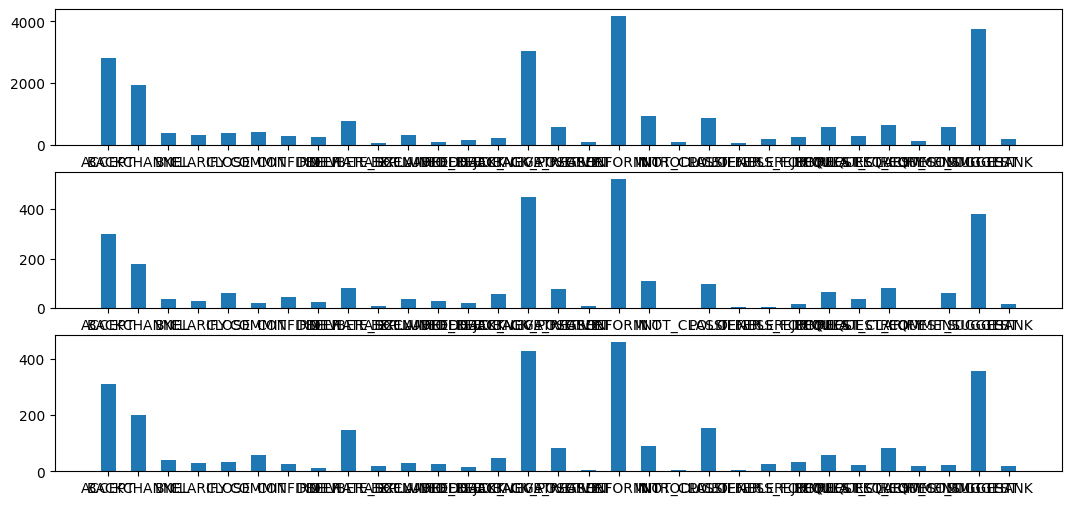

In [205]:
label_counters = {}

for split in ["train", "validation", "test"]:
  label_counters[split] = Counter(dataset_vm2[split]['Label'])

# Plotting bar charts
plt.figure(figsize=(13,6))

split = 'train'
tick_label = [label_tags[ind] for ind in label_counters[split].keys()] # Converting indexes (Label) to Dialogue_Acts
plt.subplot(311)
plt.bar(label_counters[split].keys(), label_counters[split].values(), width=0.5, tick_label=tick_label, label=split)

split = 'validation'
tick_label = [label_tags[ind] for ind in label_counters[split].keys()] # Converting indexes (Label) to Dialogue_Acts
plt.subplot(312)
plt.bar(label_counters[split].keys(), label_counters[split].values(), width=0.5, tick_label=tick_label, label=split)

split = 'test'
tick_label = [label_tags[ind] for ind in label_counters[split].keys()] # Converting indexes (Label) to Dialogue_Acts
plt.subplot(313)
plt.bar(label_counters[split].keys(), label_counters[split].values(), width=0.5, tick_label=tick_label, label=split)

plt.show()

### Speaker: Not used

Counter({'A': 12540, 'B': 12520})


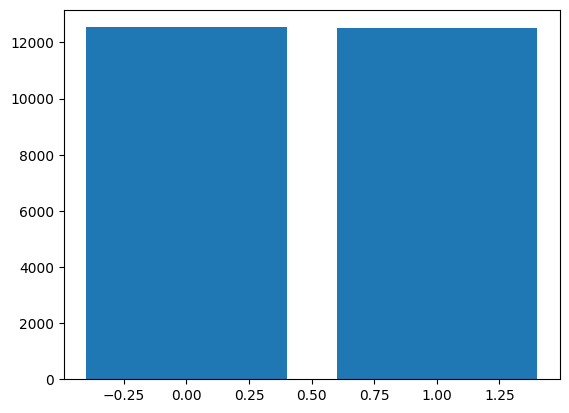

In [206]:
speaker_counter = Counter(dataset_vm2['train']['Speaker'])

print(speaker_counter)

plt.bar(range(len(speaker_counter)), speaker_counter.values(), width=0.8)
plt.show()

### Sentence length (with space splitting)

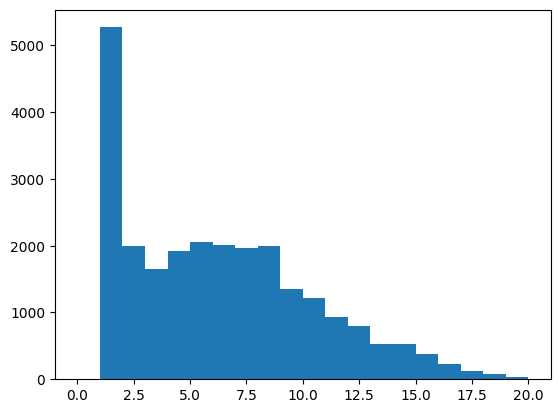

In [208]:
lengths = list(map(lambda s: len(s.split(" ")), dataset_vm2['train']['Utterance']))

plt.hist(lengths, bins=20, range=(0,20))
plt.show()

## Preprocessing 1: With nltk

In [78]:
tok = TweetTokenizer()

# We decided to replace <'s> by < s> because of the high number of tokens not recognised by the torchtext vocab
tok.tokenize("This code's not from lab 3!".lower().replace("'s", " s"))

['this', 'code', 's', 'not', 'from', 'lab', '3', '!']

In [161]:
def preprocess_one(entry, vocab_stoi, max_length=50):
  text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry.lower().replace("'s", " s"))]
  padded_text = None
  if len(text) < max_length:   padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
  elif len(text) > max_length: padded_text = text[:max_length]
  else:                        padded_text = text
  return padded_text

def preprocess_all(entries, vocab_stoi, max_length=50):
  res = {}
  res['Utterance'] = [preprocess_one(entry, vocab_stoi, max_length=max_length) for entry in entries['Utterance']]
  res['Label'] = entries['Label']
  return res

# Require the correct labels for Utterance and Label
def preprocess_dataset(dataset, max_length=50):
  processed_dataset = DatasetDict()
  processed_dataset['train'] = dataset['train'].map(lambda e: preprocess_all(e, pretrained_vocab.get_stoi(), max_length), batched=True)
  processed_dataset['validation'] = dataset['validation'].map(lambda e: preprocess_all(e, pretrained_vocab.get_stoi(), max_length), batched=True)
  processed_dataset['test'] = dataset['test'].map(lambda e: preprocess_all(e, pretrained_vocab.get_stoi(), max_length), batched=True)
  return processed_dataset

## Torch Dataset and DataLoader

In [73]:
class DialogueActDataset(Dataset):
    def __init__(self, data, args):
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "Utterance": torch.tensor(self.data[idx]['Utterance']),
          "Label": torch.tensor(self.data[idx]['Label'])
      }
      return item

In [74]:
def create_data_loaders_1(preprocedded_dataset, args):
  train_loader = DataLoader(DialogueActDataset(preprocedded_dataset['train'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
  val_loader   = DataLoader(DialogueActDataset(preprocedded_dataset['validation'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
  test_loader  = DataLoader(DialogueActDataset(preprocedded_dataset['test'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
  return train_loader, val_loader, test_loader

## **FastText**

### **Choosing the dataset, batch size and max length for processing:**

In [209]:

############ TO CHANGE IF NEEDED ###########

dataset_name = "vm2"
args = {'bsize': 64, 'max_length': 50}

############################################

args["dataset_name"] = dataset_name

recognised_datasets = ["maptask", "mrda", "loria", "vm2"]
silicone = ["maptask", "mrda"]
miam = ["loria", "vm2"]
if dataset_name in recognised_datasets:
  if dataset_name in silicone:
    dataset = load_dataset("silicone", dataset_name)
  elif dataset_name in miam:
    dataset = load_dataset("miam", dataset_name)
  else:
    print("Unexpected error")

  preprocedded_dataset = preprocess_dataset(dataset, max_length=args['max_length'])
  train_loader, val_loader, test_loader = create_data_loaders_1(preprocedded_dataset, args)

  num_class = len(np.unique(dataset["train"]["Label"]))
  args["num_class"] = num_class

else:
  print("The dataset name is not in the dataset list:", recognised_datasets)


  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/25060 [00:00<?, ? examples/s]

Map:   0%|          | 0/2860 [00:00<?, ? examples/s]

Map:   0%|          | 0/2855 [00:00<?, ? examples/s]

### Pytorch Model

In [210]:
if torch.cuda.is_available():
  device = 'cuda:0'
  print('DEVICE = ', torch.cuda.get_device_name(0) )
else:
  device = 'cpu'
  print('DEVICE = ', 'CPU')

DEVICE =  CPU


In [166]:
class DialogueModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pretrained_vectors=None):
        super(DialogueModel, self).__init__()
        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        self.hidden_linear_layer = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.classification_layer = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        self.softmax = nn.Softmax(dim=1)
        # self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x  = self.ebd(x)
        x  = x.mean(1)
        h  = torch.relu(self.hidden_linear_layer( x ))
        # h  = self.dropout(h)
        h  = self.classification_layer(h)
        logits = self.softmax(h)
        return logits

In [211]:
sizes = next(iter(train_loader))['Utterance'].size()
batchsize = sizes[0]
inputdim  = sizes[1]

hiddendim = 300         # From FastText embeddings
outputdim = num_class   # Depends on the dataset

print(f"Batch Size: {batchsize}\nInput Dimension: {inputdim}\nHidden Dimension: {hiddendim}\nOutput Dimension: {outputdim}")

dialogue_model = DialogueModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)

Batch Size: 64
Input Dimension: 50
Hidden Dimension: 300
Output Dimension: 31


In [212]:
dialogue_model

DialogueModel(
  (ebd): Embedding(2519370, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=31, bias=True)
  (softmax): Softmax(dim=1)
)

### Training functions

In [213]:
def train(model, optimizer, ep, args):
  model.train()
  loss_it, acc_it = list(), list()

  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=train_loader.__len__()):
    
    # put the batch to the correct device
    batch = {'Utterance': batch['Utterance'].to(device), 'Label': batch['Label'].to(device)}

    optimizer.zero_grad()
    logits = model(batch['Utterance'])

    # Weights to balance data
    b_counter = Counter(batch['Label'].detach().cpu().tolist())
    b_weights = torch.tensor( [ sum(batch['Label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(args['num_class'])) ] )
    b_weights = b_weights.to(device)

    loss_function = nn.CrossEntropyLoss(weight=b_weights)
    loss = loss_function(logits, batch['Label'])

    loss.backward()
    optimizer.step()
    loss_it.append(loss.item())

    _, tag_seq  = torch.max(logits, 1)
    
    correct = (tag_seq.flatten() == batch['Label'].flatten()).float().sum()
    acc = correct / batch['Label'].flatten().size(0)
    acc_it.append(acc.item())

  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : Training : (loss %s) (acc %s)" %(str(ep), args['max_eps'], sum(loss_it)/len(loss_it), sum(acc_it) / len(acc_it) ))


In [214]:
def inference(target, loader, model):
  model.eval()
  loss_it, acc_it, f1_it = list(), list(), list()
  preds, trues = list(), list()

  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    with torch.no_grad():

      # put the batch to the correct device
      batch = {'Utterance': batch['Utterance'].to(device), 'Label': batch['Label'].to(device)}

      logits = model(batch['Utterance'])
      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(logits, batch['Label'])
      loss_it.append(loss.item())

      _, tag_seq  = torch.max(logits, 1)
      
      correct = (tag_seq.flatten() == batch['Label'].flatten()).float().sum()
      acc = correct / batch['Label'].flatten().size(0)
      acc_it.append(acc.item())
      
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['Label'].cpu().detach().tolist())

  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  print("%s : (loss %s) (acc %s)" % (target, sum(loss_it)/len(loss_it), sum(acc_it) / len(acc_it) ))

  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

In [179]:
def run_epochs(model, args):

  model.to(device)
  print("model set to %s device" % (device) )

  optimizer = optim.AdamW(model.parameters(), lr = args['lr'])

  val_ep_losses = list()
  val_ep_acc = list()
  for ep in range(args['max_eps']):

    train(model, optimizer, ep, args)
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)
    
    val_ep_losses.append(val_loss_it_avg)
    val_ep_acc.append(val_acc_it_avg)

  return val_ep_losses, val_ep_acc
    

### Start Training

In [215]:
# Device for torch:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu' just to use the cpu
print('device', device)

# Set the main arguments:
# args = {'bsize': 64, 'max_length': 50} # if needed

args.update({'max_eps': 10, 'lr': 0.001, 'num_class': num_class})

dialogue_model = DialogueModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)
loss_list_val, acc_list_val = run_epochs(dialogue_model, args)

device cpu
model set to cpu device





Epoch 0::   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 0::   0%|          | 1/391 [00:00<01:03,  6.12it/s]


Epoch 0::   2%|▏         | 7/391 [00:00<00:13, 28.98it/s]


Epoch 0::   3%|▎         | 11/391 [00:00<00:12, 29.88it/s]


Epoch 0::   4%|▍         | 15/391 [00:00<00:11, 32.95it/s]


Epoch 0::   5%|▍         | 19/391 [00:00<00:11, 33.75it/s]


Epoch 0::   6%|▌         | 24/391 [00:00<00:10, 35.39it/s]


Epoch 0::   7%|▋         | 28/391 [00:00<00:10, 34.40it/s]


Epoch 0::   8%|▊         | 33/391 [00:00<00:09, 38.34it/s]


Epoch 0::  10%|▉         | 38/391 [00:01<00:09, 38.37it/s]


Epoch 0::  11%|█         | 43/391 [00:01<00:08, 39.04it/s]


Epoch 0::  12%|█▏        | 47/391 [00:01<00:09, 37.04it/s]


Epoch 0::  13%|█▎        | 51/391 [00:01<00:09, 36.07it/s]


Epoch 0::  14%|█▍        | 55/391 [00:01<00:09, 37.10it/s]


Epoch 0::  15%|█▌        | 60/391 [00:01<00:08, 38.99it/s]


Epoch 0::  17%|█▋        | 65/391 [00:01<00:08, 39.13it/s]


Epoch 0::  18%|█▊        | 70/39

Epoch 0/10 : Training : (loss 3.3768386103003225) (acc 0.23709239130434784)






validation::   0%|          | 0/44 [00:00<?, ?it/s]


validation::   5%|▍         | 2/44 [00:00<00:02, 19.12it/s]


validation::  16%|█▌        | 7/44 [00:00<00:01, 35.58it/s]


validation::  30%|██▉       | 13/44 [00:00<00:00, 35.74it/s]


validation::  39%|███▊      | 17/44 [00:00<00:00, 35.35it/s]


validation::  52%|█████▏    | 23/44 [00:00<00:00, 40.40it/s]


validation::  66%|██████▌   | 29/44 [00:00<00:00, 43.00it/s]


validation::  77%|███████▋  | 34/44 [00:00<00:00, 44.01it/s]


validation::  89%|████████▊ | 39/44 [00:00<00:00, 44.20it/s]


validation:: 100%|██████████| 44/44 [00:01<00:00, 34.04it/s]

validation : (loss 3.1767117381095886) (acc 0.3583096590909091)






Epoch 1::   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 1::   1%|          | 2/391 [00:00<00:20, 19.04it/s]


Epoch 1::   2%|▏         | 7/391 [00:00<00:10, 35.53it/s]


Epoch 1::   3%|▎         | 11/391 [00:00<00:10, 34.69it/s]


Epoch 1::   4%|▍         | 15/391 [00:00<00:11, 33.42it/s]


Epoch 1::   5%|▌         | 20/391 [00:00<00:10, 36.82it/s]


Epoch 1::   6%|▌         | 24/391 [00:00<00:09, 36.93it/s]


Epoch 1::   7%|▋         | 28/391 [00:00<00:09, 37.18it/s]


Epoch 1::   8%|▊         | 32/391 [00:00<00:09, 37.52it/s]


Epoch 1::   9%|▉         | 36/391 [00:01<00:09, 38.15it/s]


Epoch 1::  10%|█         | 40/391 [00:01<00:09, 37.87it/s]


Epoch 1::  12%|█▏        | 45/391 [00:01<00:08, 38.63it/s]


Epoch 1::  13%|█▎        | 49/391 [00:01<00:09, 37.37it/s]


Epoch 1::  14%|█▎        | 53/391 [00:01<00:09, 37.20it/s]


Epoch 1::  15%|█▍        | 57/391 [00:01<00:09, 35.52it/s]


Epoch 1::  16%|█▌        | 61/391 [00:01<00:09, 35.83it/s]


Epoch 1::  17%|█▋        | 66/3

Epoch 1/10 : Training : (loss 3.3389622713903635) (acc 0.35258152173913043)






validation::   0%|          | 0/44 [00:00<?, ?it/s]


validation::  11%|█▏        | 5/44 [00:00<00:00, 39.40it/s]


validation::  20%|██        | 9/44 [00:00<00:00, 39.23it/s]


validation::  34%|███▍      | 15/44 [00:00<00:00, 41.70it/s]


validation::  45%|████▌     | 20/44 [00:00<00:00, 43.94it/s]


validation::  57%|█████▋    | 25/44 [00:00<00:00, 40.18it/s]


validation::  70%|███████   | 31/44 [00:00<00:00, 42.48it/s]


validation::  82%|████████▏ | 36/44 [00:00<00:00, 43.42it/s]


validation:: 100%|██████████| 44/44 [00:01<00:00, 35.61it/s]

validation : (loss 3.1496336514299568) (acc 0.3643465909090909)






Epoch 2::   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 2::   1%|          | 2/391 [00:00<00:22, 17.53it/s]


Epoch 2::   2%|▏         | 7/391 [00:00<00:11, 33.96it/s]


Epoch 2::   3%|▎         | 11/391 [00:00<00:11, 34.14it/s]


Epoch 2::   4%|▍         | 15/391 [00:00<00:10, 35.86it/s]


Epoch 2::   5%|▍         | 19/391 [00:00<00:10, 34.65it/s]


Epoch 2::   6%|▌         | 24/391 [00:00<00:09, 37.44it/s]


Epoch 2::   7%|▋         | 28/391 [00:00<00:09, 36.96it/s]


Epoch 2::   8%|▊         | 32/391 [00:00<00:09, 35.91it/s]


Epoch 2::   9%|▉         | 37/391 [00:01<00:09, 37.27it/s]


Epoch 2::  11%|█         | 42/391 [00:01<00:09, 38.48it/s]


Epoch 2::  12%|█▏        | 46/391 [00:01<00:09, 37.43it/s]


Epoch 2::  13%|█▎        | 50/391 [00:01<00:08, 38.03it/s]


Epoch 2::  14%|█▍        | 54/391 [00:01<00:09, 37.38it/s]


Epoch 2::  15%|█▍        | 58/391 [00:01<00:08, 37.07it/s]


Epoch 2::  16%|█▌        | 62/391 [00:01<00:08, 36.64it/s]


Epoch 2::  17%|█▋        | 67/3

Epoch 2/10 : Training : (loss 3.326090057792566) (acc 0.37092391304347827)






validation::   0%|          | 0/44 [00:00<?, ?it/s]


validation::   2%|▏         | 1/44 [00:00<00:05,  7.44it/s]


validation::  11%|█▏        | 5/44 [00:00<00:01, 23.39it/s]


validation::  20%|██        | 9/44 [00:00<00:01, 22.19it/s]


validation::  27%|██▋       | 12/44 [00:00<00:01, 24.08it/s]


validation::  34%|███▍      | 15/44 [00:00<00:01, 22.10it/s]


validation::  43%|████▎     | 19/44 [00:00<00:01, 22.79it/s]


validation::  52%|█████▏    | 23/44 [00:01<00:00, 24.27it/s]


validation::  61%|██████▏   | 27/44 [00:01<00:00, 24.97it/s]


validation::  68%|██████▊   | 30/44 [00:01<00:00, 25.74it/s]


validation::  75%|███████▌  | 33/44 [00:01<00:00, 22.28it/s]


validation::  82%|████████▏ | 36/44 [00:01<00:00, 23.73it/s]


validation::  89%|████████▊ | 39/44 [00:01<00:00, 21.64it/s]


validation:: 100%|██████████| 44/44 [00:02<00:00, 20.70it/s]

validation : (loss 3.14224989305843) (acc 0.3664772727272727)






Epoch 3::   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 3::   1%|          | 2/391 [00:00<00:24, 15.62it/s]


Epoch 3::   2%|▏         | 7/391 [00:00<00:12, 31.52it/s]


Epoch 3::   3%|▎         | 11/391 [00:00<00:11, 33.26it/s]


Epoch 3::   4%|▍         | 15/391 [00:00<00:10, 34.29it/s]


Epoch 3::   5%|▍         | 19/391 [00:00<00:10, 34.88it/s]


Epoch 3::   6%|▌         | 23/391 [00:00<00:10, 34.06it/s]


Epoch 3::   7%|▋         | 29/391 [00:00<00:09, 39.52it/s]


Epoch 3::   8%|▊         | 33/391 [00:00<00:09, 38.26it/s]


Epoch 3::   9%|▉         | 37/391 [00:01<00:09, 37.92it/s]


Epoch 3::  10%|█         | 41/391 [00:01<00:09, 36.86it/s]


Epoch 3::  12%|█▏        | 45/391 [00:01<00:09, 36.12it/s]


Epoch 3::  13%|█▎        | 49/391 [00:01<00:09, 35.20it/s]


Epoch 3::  14%|█▍        | 54/391 [00:01<00:08, 37.89it/s]


Epoch 3::  15%|█▍        | 58/391 [00:01<00:09, 36.56it/s]


Epoch 3::  16%|█▌        | 62/391 [00:01<00:09, 35.93it/s]


Epoch 3::  17%|█▋        | 66/3

Epoch 3/10 : Training : (loss 3.315766274166839) (acc 0.37779731457800514)






validation::   0%|          | 0/44 [00:00<?, ?it/s]


validation::   2%|▏         | 1/44 [00:00<00:07,  6.06it/s]


validation::  14%|█▎        | 6/44 [00:00<00:01, 20.43it/s]


validation::  23%|██▎       | 10/44 [00:00<00:01, 24.96it/s]


validation::  30%|██▉       | 13/44 [00:00<00:01, 24.49it/s]


validation::  36%|███▋      | 16/44 [00:00<00:01, 24.91it/s]


validation::  43%|████▎     | 19/44 [00:00<00:01, 24.31it/s]


validation::  52%|█████▏    | 23/44 [00:01<00:00, 22.12it/s]


validation::  61%|██████▏   | 27/44 [00:01<00:00, 25.83it/s]


validation::  68%|██████▊   | 30/44 [00:01<00:00, 22.63it/s]


validation::  80%|███████▉  | 35/44 [00:01<00:00, 25.55it/s]


validation::  89%|████████▊ | 39/44 [00:01<00:00, 24.54it/s]


validation:: 100%|██████████| 44/44 [00:02<00:00, 20.66it/s]

validation : (loss 3.134203331037001) (acc 0.35191761363636365)






Epoch 4::   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 4::   0%|          | 1/391 [00:00<00:55,  6.97it/s]


Epoch 4::   1%|▏         | 5/391 [00:00<00:20, 18.93it/s]


Epoch 4::   2%|▏         | 9/391 [00:00<00:16, 23.03it/s]


Epoch 4::   3%|▎         | 13/391 [00:00<00:13, 27.83it/s]


Epoch 4::   4%|▍         | 17/391 [00:00<00:11, 31.32it/s]


Epoch 4::   6%|▌         | 22/391 [00:00<00:10, 35.37it/s]


Epoch 4::   7%|▋         | 26/391 [00:00<00:10, 33.76it/s]


Epoch 4::   8%|▊         | 30/391 [00:01<00:10, 33.51it/s]


Epoch 4::   9%|▊         | 34/391 [00:01<00:10, 33.92it/s]


Epoch 4::  10%|▉         | 38/391 [00:01<00:10, 34.63it/s]


Epoch 4::  11%|█         | 43/391 [00:01<00:09, 38.13it/s]


Epoch 4::  12%|█▏        | 47/391 [00:01<00:09, 38.15it/s]


Epoch 4::  13%|█▎        | 51/391 [00:01<00:08, 38.14it/s]


Epoch 4::  14%|█▍        | 55/391 [00:01<00:08, 38.54it/s]


Epoch 4::  15%|█▌        | 59/391 [00:01<00:08, 38.71it/s]


Epoch 4::  16%|█▌        | 63/39

Epoch 4/10 : Training : (loss 3.3103660274954403) (acc 0.3827125959079284)






validation::   0%|          | 0/44 [00:00<?, ?it/s]


validation::   2%|▏         | 1/44 [00:00<00:05,  7.91it/s]


validation::  11%|█▏        | 5/44 [00:00<00:02, 18.53it/s]


validation::  20%|██        | 9/44 [00:00<00:01, 22.08it/s]


validation::  30%|██▉       | 13/44 [00:00<00:01, 23.41it/s]


validation::  39%|███▊      | 17/44 [00:00<00:01, 24.46it/s]


validation::  48%|████▊     | 21/44 [00:00<00:00, 25.15it/s]


validation::  57%|█████▋    | 25/44 [00:01<00:00, 25.37it/s]


validation::  66%|██████▌   | 29/44 [00:01<00:00, 25.12it/s]


validation::  75%|███████▌  | 33/44 [00:01<00:00, 25.58it/s]


validation::  84%|████████▍ | 37/44 [00:01<00:00, 25.67it/s]


validation:: 100%|██████████| 44/44 [00:02<00:00, 21.78it/s]

validation : (loss 3.1203639778223904) (acc 0.37642045454545453)






Epoch 5::   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 5::   0%|          | 1/391 [00:00<00:41,  9.44it/s]


Epoch 5::   1%|          | 3/391 [00:00<00:25, 15.45it/s]


Epoch 5::   2%|▏         | 6/391 [00:00<00:21, 18.06it/s]


Epoch 5::   2%|▏         | 9/391 [00:00<00:17, 22.06it/s]


Epoch 5::   3%|▎         | 12/391 [00:00<00:19, 19.39it/s]


Epoch 5::   4%|▍         | 16/391 [00:00<00:17, 21.10it/s]


Epoch 5::   5%|▍         | 19/391 [00:00<00:16, 22.57it/s]


Epoch 5::   6%|▌         | 22/391 [00:01<00:16, 22.55it/s]


Epoch 5::   6%|▋         | 25/391 [00:01<00:16, 22.43it/s]


Epoch 5::   7%|▋         | 28/391 [00:01<00:16, 21.81it/s]


Epoch 5::   8%|▊         | 31/391 [00:01<00:17, 20.97it/s]


Epoch 5::   9%|▉         | 36/391 [00:01<00:13, 25.52it/s]


Epoch 5::  10%|█         | 40/391 [00:01<00:12, 28.01it/s]


Epoch 5::  11%|█▏        | 44/391 [00:01<00:12, 28.83it/s]


Epoch 5::  12%|█▏        | 48/391 [00:01<00:11, 30.87it/s]


Epoch 5::  13%|█▎        | 52/391

Epoch 5/10 : Training : (loss 3.3042773773603122) (acc 0.3866687979539642)






validation::   0%|          | 0/44 [00:00<?, ?it/s]


validation::   5%|▍         | 2/44 [00:00<00:03, 12.23it/s]


validation::  16%|█▌        | 7/44 [00:00<00:01, 25.86it/s]


validation::  25%|██▌       | 11/44 [00:00<00:01, 25.66it/s]


validation::  34%|███▍      | 15/44 [00:00<00:01, 25.40it/s]


validation::  43%|████▎     | 19/44 [00:00<00:00, 25.41it/s]


validation::  52%|█████▏    | 23/44 [00:00<00:00, 25.30it/s]


validation::  61%|██████▏   | 27/44 [00:01<00:00, 25.32it/s]


validation::  70%|███████   | 31/44 [00:01<00:00, 27.12it/s]


validation::  80%|███████▉  | 35/44 [00:01<00:00, 29.14it/s]


validation:: 100%|██████████| 44/44 [00:01<00:00, 22.76it/s]

validation : (loss 3.1081810376860877) (acc 0.3810369318181818)






Epoch 6::   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 6::   0%|          | 1/391 [00:00<01:00,  6.42it/s]


Epoch 6::   2%|▏         | 6/391 [00:00<00:15, 24.34it/s]


Epoch 6::   2%|▏         | 9/391 [00:00<00:17, 21.64it/s]


Epoch 6::   3%|▎         | 12/391 [00:00<00:17, 22.09it/s]


Epoch 6::   4%|▍         | 15/391 [00:00<00:17, 21.32it/s]


Epoch 6::   5%|▍         | 19/391 [00:00<00:15, 24.32it/s]


Epoch 6::   6%|▌         | 22/391 [00:00<00:14, 24.99it/s]


Epoch 6::   6%|▋         | 25/391 [00:01<00:16, 21.59it/s]


Epoch 6::   7%|▋         | 28/391 [00:01<00:15, 23.11it/s]


Epoch 6::   8%|▊         | 31/391 [00:01<00:16, 22.41it/s]


Epoch 6::   9%|▊         | 34/391 [00:01<00:16, 21.19it/s]


Epoch 6::  10%|▉         | 38/391 [00:01<00:15, 22.78it/s]


Epoch 6::  11%|█         | 42/391 [00:01<00:13, 26.05it/s]


Epoch 6::  12%|█▏        | 45/391 [00:02<00:15, 21.69it/s]


Epoch 6::  13%|█▎        | 49/391 [00:02<00:14, 24.10it/s]


Epoch 6::  13%|█▎        | 52/39

Epoch 6/10 : Training : (loss 3.304760768895259) (acc 0.38798753196930946)






validation::   0%|          | 0/44 [00:00<?, ?it/s]


validation::   7%|▋         | 3/44 [00:00<00:01, 28.14it/s]


validation::  20%|██        | 9/44 [00:00<00:00, 41.39it/s]


validation::  32%|███▏      | 14/44 [00:00<00:00, 41.63it/s]


validation::  43%|████▎     | 19/44 [00:00<00:00, 42.38it/s]


validation::  55%|█████▍    | 24/44 [00:00<00:00, 40.80it/s]


validation::  66%|██████▌   | 29/44 [00:00<00:00, 40.61it/s]


validation::  77%|███████▋  | 34/44 [00:00<00:00, 37.02it/s]


validation::  86%|████████▋ | 38/44 [00:01<00:00, 32.71it/s]


validation:: 100%|██████████| 44/44 [00:01<00:00, 27.64it/s]

validation : (loss 3.1021310199390757) (acc 0.38707386363636365)






Epoch 7::   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 7::   0%|          | 1/391 [00:00<01:02,  6.23it/s]


Epoch 7::   2%|▏         | 6/391 [00:00<00:19, 20.05it/s]


Epoch 7::   2%|▏         | 8/391 [00:00<00:19, 19.87it/s]


Epoch 7::   3%|▎         | 11/391 [00:00<00:16, 22.67it/s]


Epoch 7::   4%|▎         | 14/391 [00:00<00:15, 23.70it/s]


Epoch 7::   4%|▍         | 17/391 [00:00<00:15, 24.08it/s]


Epoch 7::   5%|▌         | 20/391 [00:00<00:16, 22.77it/s]


Epoch 7::   6%|▌         | 23/391 [00:01<00:15, 24.41it/s]


Epoch 7::   7%|▋         | 26/391 [00:01<00:14, 25.02it/s]


Epoch 7::   7%|▋         | 29/391 [00:01<00:17, 21.17it/s]


Epoch 7::   8%|▊         | 33/391 [00:01<00:15, 23.61it/s]


Epoch 7::   9%|▉         | 37/391 [00:01<00:13, 25.43it/s]


Epoch 7::  10%|█         | 40/391 [00:01<00:13, 25.29it/s]


Epoch 7::  11%|█         | 43/391 [00:01<00:14, 23.70it/s]


Epoch 7::  12%|█▏        | 47/391 [00:02<00:14, 24.28it/s]


Epoch 7::  13%|█▎        | 50/39

Epoch 7/10 : Training : (loss 3.3013534802000235) (acc 0.3944213554987212)






validation::   0%|          | 0/44 [00:00<?, ?it/s]


validation::   7%|▋         | 3/44 [00:00<00:01, 28.82it/s]


validation::  16%|█▌        | 7/44 [00:00<00:01, 35.27it/s]


validation::  30%|██▉       | 13/44 [00:00<00:00, 40.41it/s]


validation::  43%|████▎     | 19/44 [00:00<00:00, 42.24it/s]


validation::  55%|█████▍    | 24/44 [00:00<00:00, 43.88it/s]


validation::  66%|██████▌   | 29/44 [00:00<00:00, 37.84it/s]


validation::  80%|███████▉  | 35/44 [00:00<00:00, 39.92it/s]


validation:: 100%|██████████| 44/44 [00:01<00:00, 34.79it/s]

validation : (loss 3.1007122180678626) (acc 0.3888494318181818)






Epoch 8::   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 8::   0%|          | 1/391 [00:00<00:53,  7.25it/s]


Epoch 8::   1%|▏         | 5/391 [00:00<00:17, 21.81it/s]


Epoch 8::   2%|▏         | 8/391 [00:00<00:15, 24.51it/s]


Epoch 8::   3%|▎         | 11/391 [00:00<00:15, 23.94it/s]


Epoch 8::   4%|▎         | 14/391 [00:00<00:15, 24.29it/s]


Epoch 8::   4%|▍         | 17/391 [00:00<00:15, 24.28it/s]


Epoch 8::   5%|▌         | 20/391 [00:00<00:15, 23.27it/s]


Epoch 8::   6%|▌         | 23/391 [00:01<00:16, 22.09it/s]


Epoch 8::   7%|▋         | 26/391 [00:01<00:16, 22.71it/s]


Epoch 8::   7%|▋         | 29/391 [00:01<00:15, 23.30it/s]


Epoch 8::   8%|▊         | 32/391 [00:01<00:16, 21.82it/s]


Epoch 8::   9%|▉         | 35/391 [00:01<00:15, 22.61it/s]


Epoch 8::  10%|▉         | 38/391 [00:01<00:17, 20.53it/s]


Epoch 8::  10%|█         | 41/391 [00:01<00:16, 21.43it/s]


Epoch 8::  11%|█▏        | 44/391 [00:02<00:16, 20.94it/s]


Epoch 8::  12%|█▏        | 48/39

Epoch 8/10 : Training : (loss 3.298285036745584) (acc 0.3946611253196931)






validation::   0%|          | 0/44 [00:00<?, ?it/s]


validation::   9%|▉         | 4/44 [00:00<00:01, 39.18it/s]


validation::  18%|█▊        | 8/44 [00:00<00:00, 38.86it/s]


validation::  27%|██▋       | 12/44 [00:00<00:00, 38.89it/s]


validation::  39%|███▊      | 17/44 [00:00<00:00, 36.81it/s]


validation::  52%|█████▏    | 23/44 [00:00<00:00, 39.97it/s]


validation::  61%|██████▏   | 27/44 [00:00<00:00, 39.88it/s]


validation::  70%|███████   | 31/44 [00:00<00:00, 38.95it/s]


validation::  80%|███████▉  | 35/44 [00:00<00:00, 38.93it/s]


validation:: 100%|██████████| 44/44 [00:01<00:00, 33.95it/s]

validation : (loss 3.0999885309826243) (acc 0.38529829545454547)






Epoch 9::   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 9::   1%|          | 2/391 [00:00<00:23, 16.75it/s]


Epoch 9::   2%|▏         | 8/391 [00:00<00:10, 36.09it/s]


Epoch 9::   3%|▎         | 12/391 [00:00<00:10, 35.71it/s]


Epoch 9::   4%|▍         | 16/391 [00:00<00:11, 32.90it/s]


Epoch 9::   5%|▌         | 20/391 [00:00<00:10, 34.69it/s]


Epoch 9::   6%|▌         | 24/391 [00:00<00:10, 33.48it/s]


Epoch 9::   7%|▋         | 28/391 [00:00<00:11, 30.40it/s]


Epoch 9::   8%|▊         | 32/391 [00:01<00:11, 32.03it/s]


Epoch 9::   9%|▉         | 36/391 [00:01<00:12, 29.27it/s]


Epoch 9::  10%|█         | 40/391 [00:01<00:14, 24.88it/s]


Epoch 9::  11%|█         | 43/391 [00:01<00:13, 25.26it/s]


Epoch 9::  12%|█▏        | 46/391 [00:01<00:13, 26.00it/s]


Epoch 9::  13%|█▎        | 49/391 [00:01<00:13, 25.15it/s]


Epoch 9::  14%|█▎        | 53/391 [00:01<00:12, 26.68it/s]


Epoch 9::  14%|█▍        | 56/391 [00:01<00:13, 25.03it/s]


Epoch 9::  15%|█▌        | 59/3

Epoch 9/10 : Training : (loss 3.297318140259179) (acc 0.3975383631713555)






validation::   0%|          | 0/44 [00:00<?, ?it/s]


validation::   5%|▍         | 2/44 [00:00<00:02, 18.67it/s]


validation::  14%|█▎        | 6/44 [00:00<00:01, 30.48it/s]


validation::  25%|██▌       | 11/44 [00:00<00:00, 38.51it/s]


validation::  34%|███▍      | 15/44 [00:00<00:00, 37.19it/s]


validation::  43%|████▎     | 19/44 [00:00<00:00, 37.12it/s]


validation::  52%|█████▏    | 23/44 [00:00<00:00, 37.71it/s]


validation::  61%|██████▏   | 27/44 [00:00<00:00, 37.79it/s]


validation::  73%|███████▎  | 32/44 [00:00<00:00, 39.96it/s]


validation::  82%|████████▏ | 36/44 [00:00<00:00, 38.55it/s]


validation:: 100%|██████████| 44/44 [00:01<00:00, 32.06it/s]

validation : (loss 3.093846093524586) (acc 0.39417613636363635)


Now let's plot the validation loss.

In [216]:
def plot_loss(loss_list):
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('epochs')
  plt.ylabel('Cross Entropy')
  plt.title('lr: {}, optim_alg:{}'.format(args['lr'], 'AdamW'))
  plt.show()

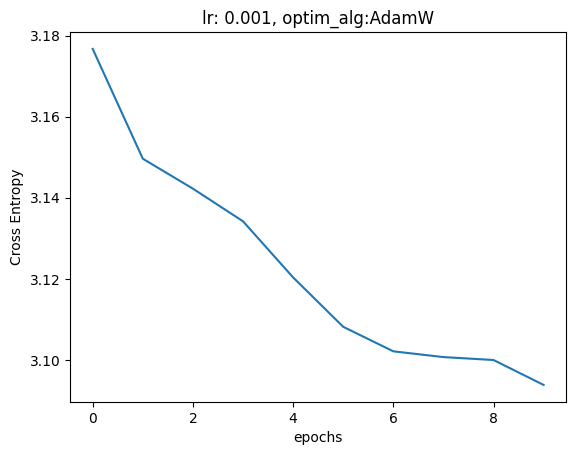

In [217]:
plot_loss(loss_list_val)

In [192]:
def plot_acc(acc_list):
  plt.plot(range(len(acc_list)), acc_list)
  plt.xlabel('epochs')
  plt.ylabel('Accuracy')
  plt.title(f"lr: { args['lr'] }, optim_alg:{'AdamW'}")
  plt.show()

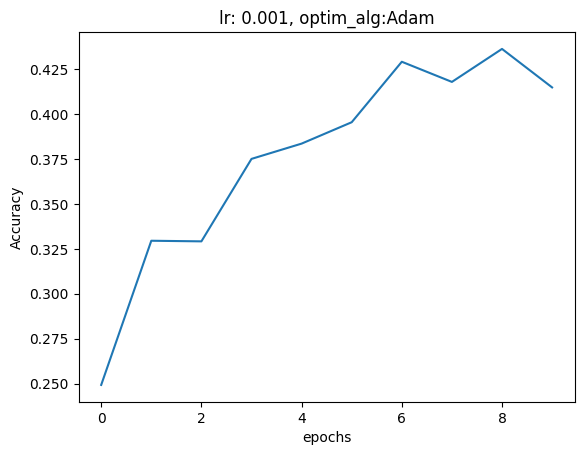

In [135]:
plot_acc(acc_list_val)

### Evaluate the Model 

In [218]:
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, dialogue_model)




test::   0%|          | 0/44 [00:00<?, ?it/s]


test::   7%|▋         | 3/44 [00:00<00:01, 29.69it/s]


test::  18%|█▊        | 8/44 [00:00<00:00, 41.35it/s]


test::  30%|██▉       | 13/44 [00:00<00:00, 39.49it/s]


test::  39%|███▊      | 17/44 [00:00<00:00, 39.45it/s]


test::  48%|████▊     | 21/44 [00:00<00:00, 38.73it/s]


test::  61%|██████▏   | 27/44 [00:00<00:00, 41.07it/s]


test::  75%|███████▌  | 33/44 [00:00<00:00, 43.33it/s]


test::  86%|████████▋ | 38/44 [00:00<00:00, 42.28it/s]


test:: 100%|██████████| 44/44 [00:01<00:00, 34.88it/s]

test : (loss 3.117465441877192) (acc 0.3739346590909091)


In [190]:
names = np.unique(dataset["train"]["Label"])
names

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [195]:
print(np.unique(trues))
print(np.unique(preds))

[ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 16 17 18 19 20 21 23 25 27 28
 29 30]
[ 0  1  5  7 17 21 30]


In [198]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(np.array(trues), np.array(preds)))   # , target_names=names)) # Remove target_names for LORIA dataset

              precision    recall  f1-score   support

           0       0.14      0.36      0.20        45
           1       0.71      0.89      0.79       210
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        19
           4       0.00      0.00      0.00        14
           5       0.80      0.77      0.78       137
           6       0.00      0.00      0.00        31
           7       0.88      0.79      0.83       215
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         6
          17       0.15      0.58      0.24        24
          18       0.00      0.00      0.00        30
          19       0.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [199]:
from sklearn.metrics import classification_report, confusion_matrix #, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

ValueError: ignored

## **BERT**

### Preprocess

In [242]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)

def preprocess_all_bert(examples):
    return tokenizer(examples["Utterance"], padding="max_length", truncation=True)

def preprocess_dataset_bert(dataset, train_size=150, eval_size=500):
  tokenized_dataset = dataset.map(preprocess_all_bert, batched=True)
  tokenized_dataset = tokenized_dataset.remove_columns(["Utterance"])
  tokenized_dataset = tokenized_dataset.rename_column("Label", "labels")
  tokenized_dataset.set_format("torch")

  reduced_processed_dataset = DatasetDict()
  reduced_processed_dataset["train"] = tokenized_dataset["train"].shuffle(seed=42).select(range(train_size))
  reduced_processed_dataset["validation"] = tokenized_dataset["validation"]
  reduced_processed_dataset["test"] = tokenized_dataset["test"].shuffle(seed=42).select(range(eval_size))
  return reduced_processed_dataset

In [239]:
def create_data_loaders_2(preprocessed_dataset, args):
  train_dataloader = DataLoader(preprocessed_dataset["train"], shuffle=True, batch_size=args['bsize'])
  eval_dataloader = DataLoader(preprocessed_dataset["test"], batch_size=args['bsize'])
  return train_dataloader, eval_dataloader


### **Choose dataset, train size, eval size and batch size**

In [285]:
############ TO CHANGE IF NEEDED ###########

dataset_name = "maptask"
args = {'bsize': 8}
train_size = 400
eval_size = 800

############################################

args["dataset_name"] = dataset_name

recognised_datasets = ["maptask", "mrda", "loria", "vm2"]
silicone = ["maptask", "mrda"]
miam = ["loria", "vm2"]
if dataset_name in recognised_datasets:
  if dataset_name in silicone:
    dataset = load_dataset("silicone", dataset_name)
  elif dataset_name in miam:
    dataset = load_dataset("miam", dataset_name)
  else:
    print("Unexpected error")

  preprocedded_dataset = preprocess_dataset_bert(dataset, train_size=train_size, eval_size=eval_size)
  train_dataloader, eval_dataloader = create_data_loaders_2(preprocedded_dataset, args)

  num_class = len(np.unique(dataset["train"]["Label"]))
  args["num_class"] = num_class

else:
  print("The dataset name is not in the dataset list:", recognised_datasets)

  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/20905 [00:00<?, ? examples/s]

Map:   0%|          | 0/2963 [00:00<?, ? examples/s]

Map:   0%|          | 0/2894 [00:00<?, ? examples/s]

### **Model and parameters**

In [286]:
small_bert_model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_class).to(device)
optimizer = optim.AdamW(small_bert_model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
print(f"Training steps: {num_training_steps}")

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

Training steps: 150


### Start Training

In [287]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

small_bert_model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:        
        for key, value in batch.items():
            inputs = {}
            for key, value in batch.items():
                if key in ['labels', 'input_ids', 'attention_mask']:
                    inputs[key] = value.to(device)
        outputs = small_bert_model(**inputs)
        loss = outputs.loss.to(device)
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/150 [00:00<?, ?it/s]

### Evaluate the model

In [288]:
from datasets import load_metric
metric = load_metric("accuracy")
small_bert_model.eval()
preds, trues = [], []
for i, batch in tqdm(enumerate(eval_dataloader), desc="evaluating", total=eval_dataloader.__len__()):
  for key, value in batch.items():
        inputs = {}
        for key, value in batch.items():
            if key in ['labels', 'input_ids', 'attention_mask']:
                inputs[key] = value.to(device)
  with torch.no_grad():
      outputs = small_bert_model(**inputs)

  logits = outputs.logits
  predictions = torch.argmax(logits, dim=-1)
  metric.add_batch(predictions=predictions, references=batch["labels"])

  _, tag_seq  = torch.max(logits, 1)
  preds.extend(tag_seq.cpu().detach().tolist())
  trues.extend(batch['labels'].cpu().detach().tolist())


metric.compute()

evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

{'accuracy': 0.26125}

In [290]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(np.array(trues).flatten(), np.array(preds).flatten()))


              precision    recall  f1-score   support

           0       0.54      0.18      0.27       185
           1       0.00      0.00      0.00        42
           2       0.00      0.00      0.00        67
           3       0.00      0.00      0.00        56
           4       0.00      0.00      0.00        63
           5       0.28      0.88      0.43       131
           6       0.00      0.00      0.00        21
           7       0.25      0.03      0.05        35
           8       0.00      0.00      0.00        57
           9       0.00      0.00      0.00        31
          10       0.00      0.00      0.00        29
          11       0.18      0.72      0.29        83

    accuracy                           0.26       800
   macro avg       0.10      0.15      0.09       800
weighted avg       0.20      0.26      0.16       800



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
